In [1]:
import seml
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
plt.rcParams['figure.dpi'] = 500

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seml/database.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def extract(
    x,
    t='weighted avg',
    metric='f1-score'
):
    try:
        w = x.loc[t][metric]
    except:
        w = np.nan
    return w
def process_df(df, metric='f1-score'):
    for i in range(1, 4):
        df[f'result.f1-score-weighted.level_{i}'] = df[f'result.classification_report.level_{i}'].apply(
            lambda x: extract(x, metric=metric)
        )
        df[f'result.f1-score-macro.level_{i}'] = df[f'result.classification_report.level_{i}'].apply(
            lambda x: extract(x, 'macro avg', metric=metric)
        )
        df[f'result.accuracy.level_{i}'] = df[f'result.classification_report.level_{i}'].apply(
            lambda x: extract(x, 'accuracy', metric='precision')
        )
        df[f'result.f1-score-weighted_query.level_{i}'] = df[f'result.classification_report_query.level_{i}'].apply(
            lambda x: extract(x, metric=metric)
        )
        df[f'result.f1-score-macro_query.level_{i}'] = df[f'result.classification_report_query.level_{i}'].apply(
            lambda x: extract(x, 'macro avg', metric=metric)
        )
        df[f'result.accuracy_query.level_{i}'] = df[f'result.classification_report_query.level_{i}'].apply(
            lambda x: extract(x, 'accuracy', metric='precision')
        )
    return df

In [3]:
def plot(df, metric):
    df = process_df(df)
    df_scores = df[df.columns[df.columns.str.contains(metric)]]
    df_scores.index = df['config.ann_levels'].astype('str')
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    df_plot = (
        df_scores
        .groupby(
            df_scores.index
        )
        .mean()
        .reindex([
            '[1]',
            '[2]',
            '[3]',
            '[1, 2]',
            '[2, 3]',
            '[1, 2, 3]',
        ])
    )
    df_std = (
        df_scores
        .groupby(
            df_scores.index
        )
        .std()
        .reindex([
            '[1]',
            '[2]',
            '[3]',
            '[1, 2]',
            '[2, 3]',
            '[1, 2, 3]',
        ])
    )
    labels = df_plot.round(2).astype('str') + ' + ' + df_std.round(2).astype('str')
    sns.heatmap(
        df_plot, 
        vmin=0, 
        vmax=1, 
        cmap='viridis', 
        annot=labels.astype('str'),
        fmt='',
        ax=ax
    )
    ax.set_title(metric)
    ax.vlines([2, 4, 6], *ax.get_ylim(), color='black')
    #plt.close()

In [4]:
results = seml.get_results('pbmc_hierarchical', to_data_frame=True)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seml/evaluation.py:80: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  parsed = pd.io.json.json_normalize(parsed, sep='.')


In [5]:
results

,_id,config.overwrite,config.db_collection,config.ann_levels,config.runs,config.seed,result.classification_report.level_1,result.classification_report_query.level_1,result.integration_scores,result.classification_report.level_2,result.classification_report_query.level_2,result.classification_report.level_3,result.classification_report_query.level_3
0,1,1,pbmc_hierarchical,[1],1.0,218024996,precision recall f1-score ...,precision recall f1-score ...,ebm knn 0 0.736433 0.932937,NaN,NaN,NaN,NaN
1,2,2,pbmc_hierarchical,[2],1.0,904283066,NaN,NaN,ebm knn 0 0.751168 0.753362,precision recall f1-sco...,precision recall f1-sco...,NaN,NaN
2,3,3,pbmc_hierarchical,[3],1.0,22917918,NaN,NaN,ebm knn 0 0.75497 0.560359,NaN,NaN,precision recall f1...,precision recall f1...
3,4,4,pbmc_hierarchical,"[1, 2]",1.0,937241106,precision recall f1-score ...,precision recall f1-score ...,ebm knn 0 0.752144 0.954776,precision recall f1-sco...,precision recall f1-sco...,NaN,NaN
4,5,5,pbmc_hierarchical,"[2, 3]",1.0,3043598,NaN,NaN,ebm knn 0 0.766446 0.797327,precision recall f1-sco...,precision recall f1-sco...,precision recall f1...,precision recall f1...
5,6,6,pbmc_hierarchical,"[1, 2, 3]",1.0,507665510,precision recall f1-score ...,precision recall f1-score ...,ebm knn 0 0.761314 0.952125,precision recall f1-sco...,precision recall f1-sco...,precision recall f1...,precision recall f1...
6,7,7,pbmc_hierarchical,[1],2.0,586049969,precision recall f1-score ...,precision recall f1-score ...,ebm knn 0 0.730508 0.94124,NaN,NaN,NaN,NaN
7,8,8,pbmc_hierarchical,[2],2.0,496739153,NaN,NaN,ebm knn 0 0.744321 0.790963,precision recall f1-sco...,precision recall f1-sco...,NaN,NaN
8,9,9,pbmc_hierarchical,[3],2.0,354513202,NaN,NaN,ebm knn 0 0.762234 0.547352,NaN,NaN,precision recall f1...,precision recall f1...
9,10,10,pbmc_hierarchical,"[1, 2]",2.0,604395287,precision recall f1-score ...,precision recall f1-score ...,ebm knn 0 0.751529 0.966449,precision recall f1-sco...,precision recall f1-sco...,NaN,NaN


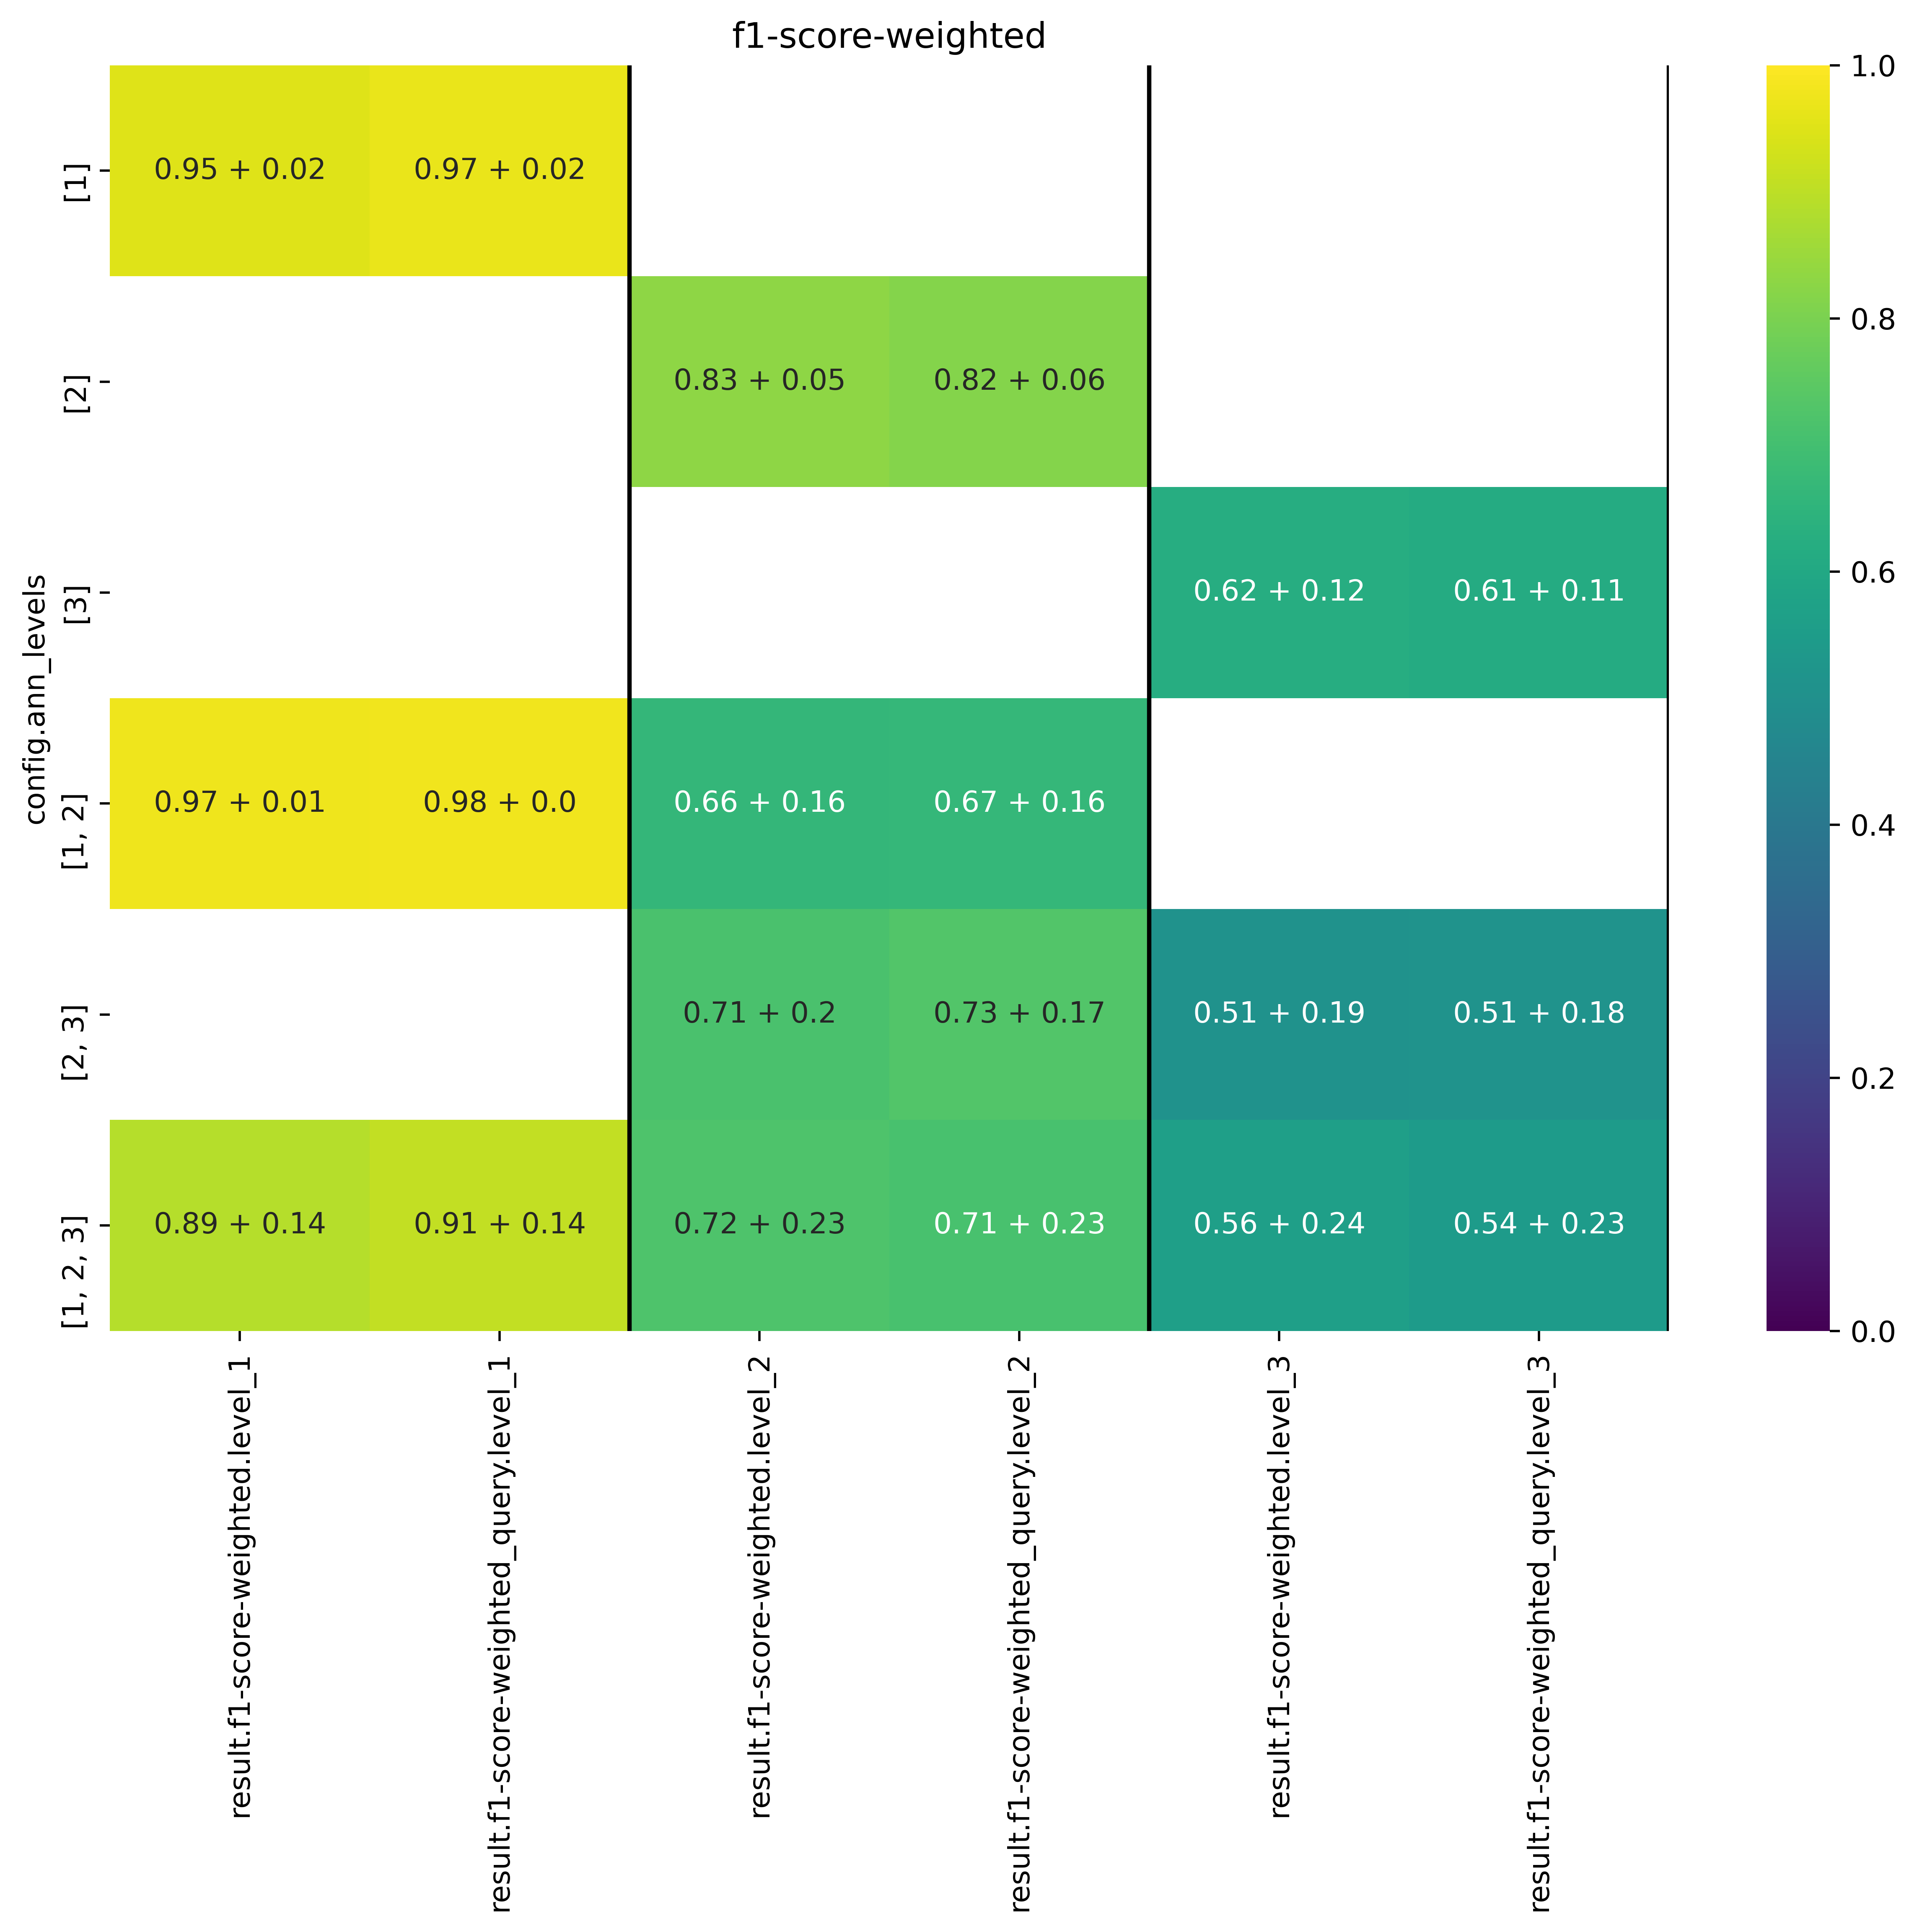

In [6]:
plot(results, 'f1-score-weighted')

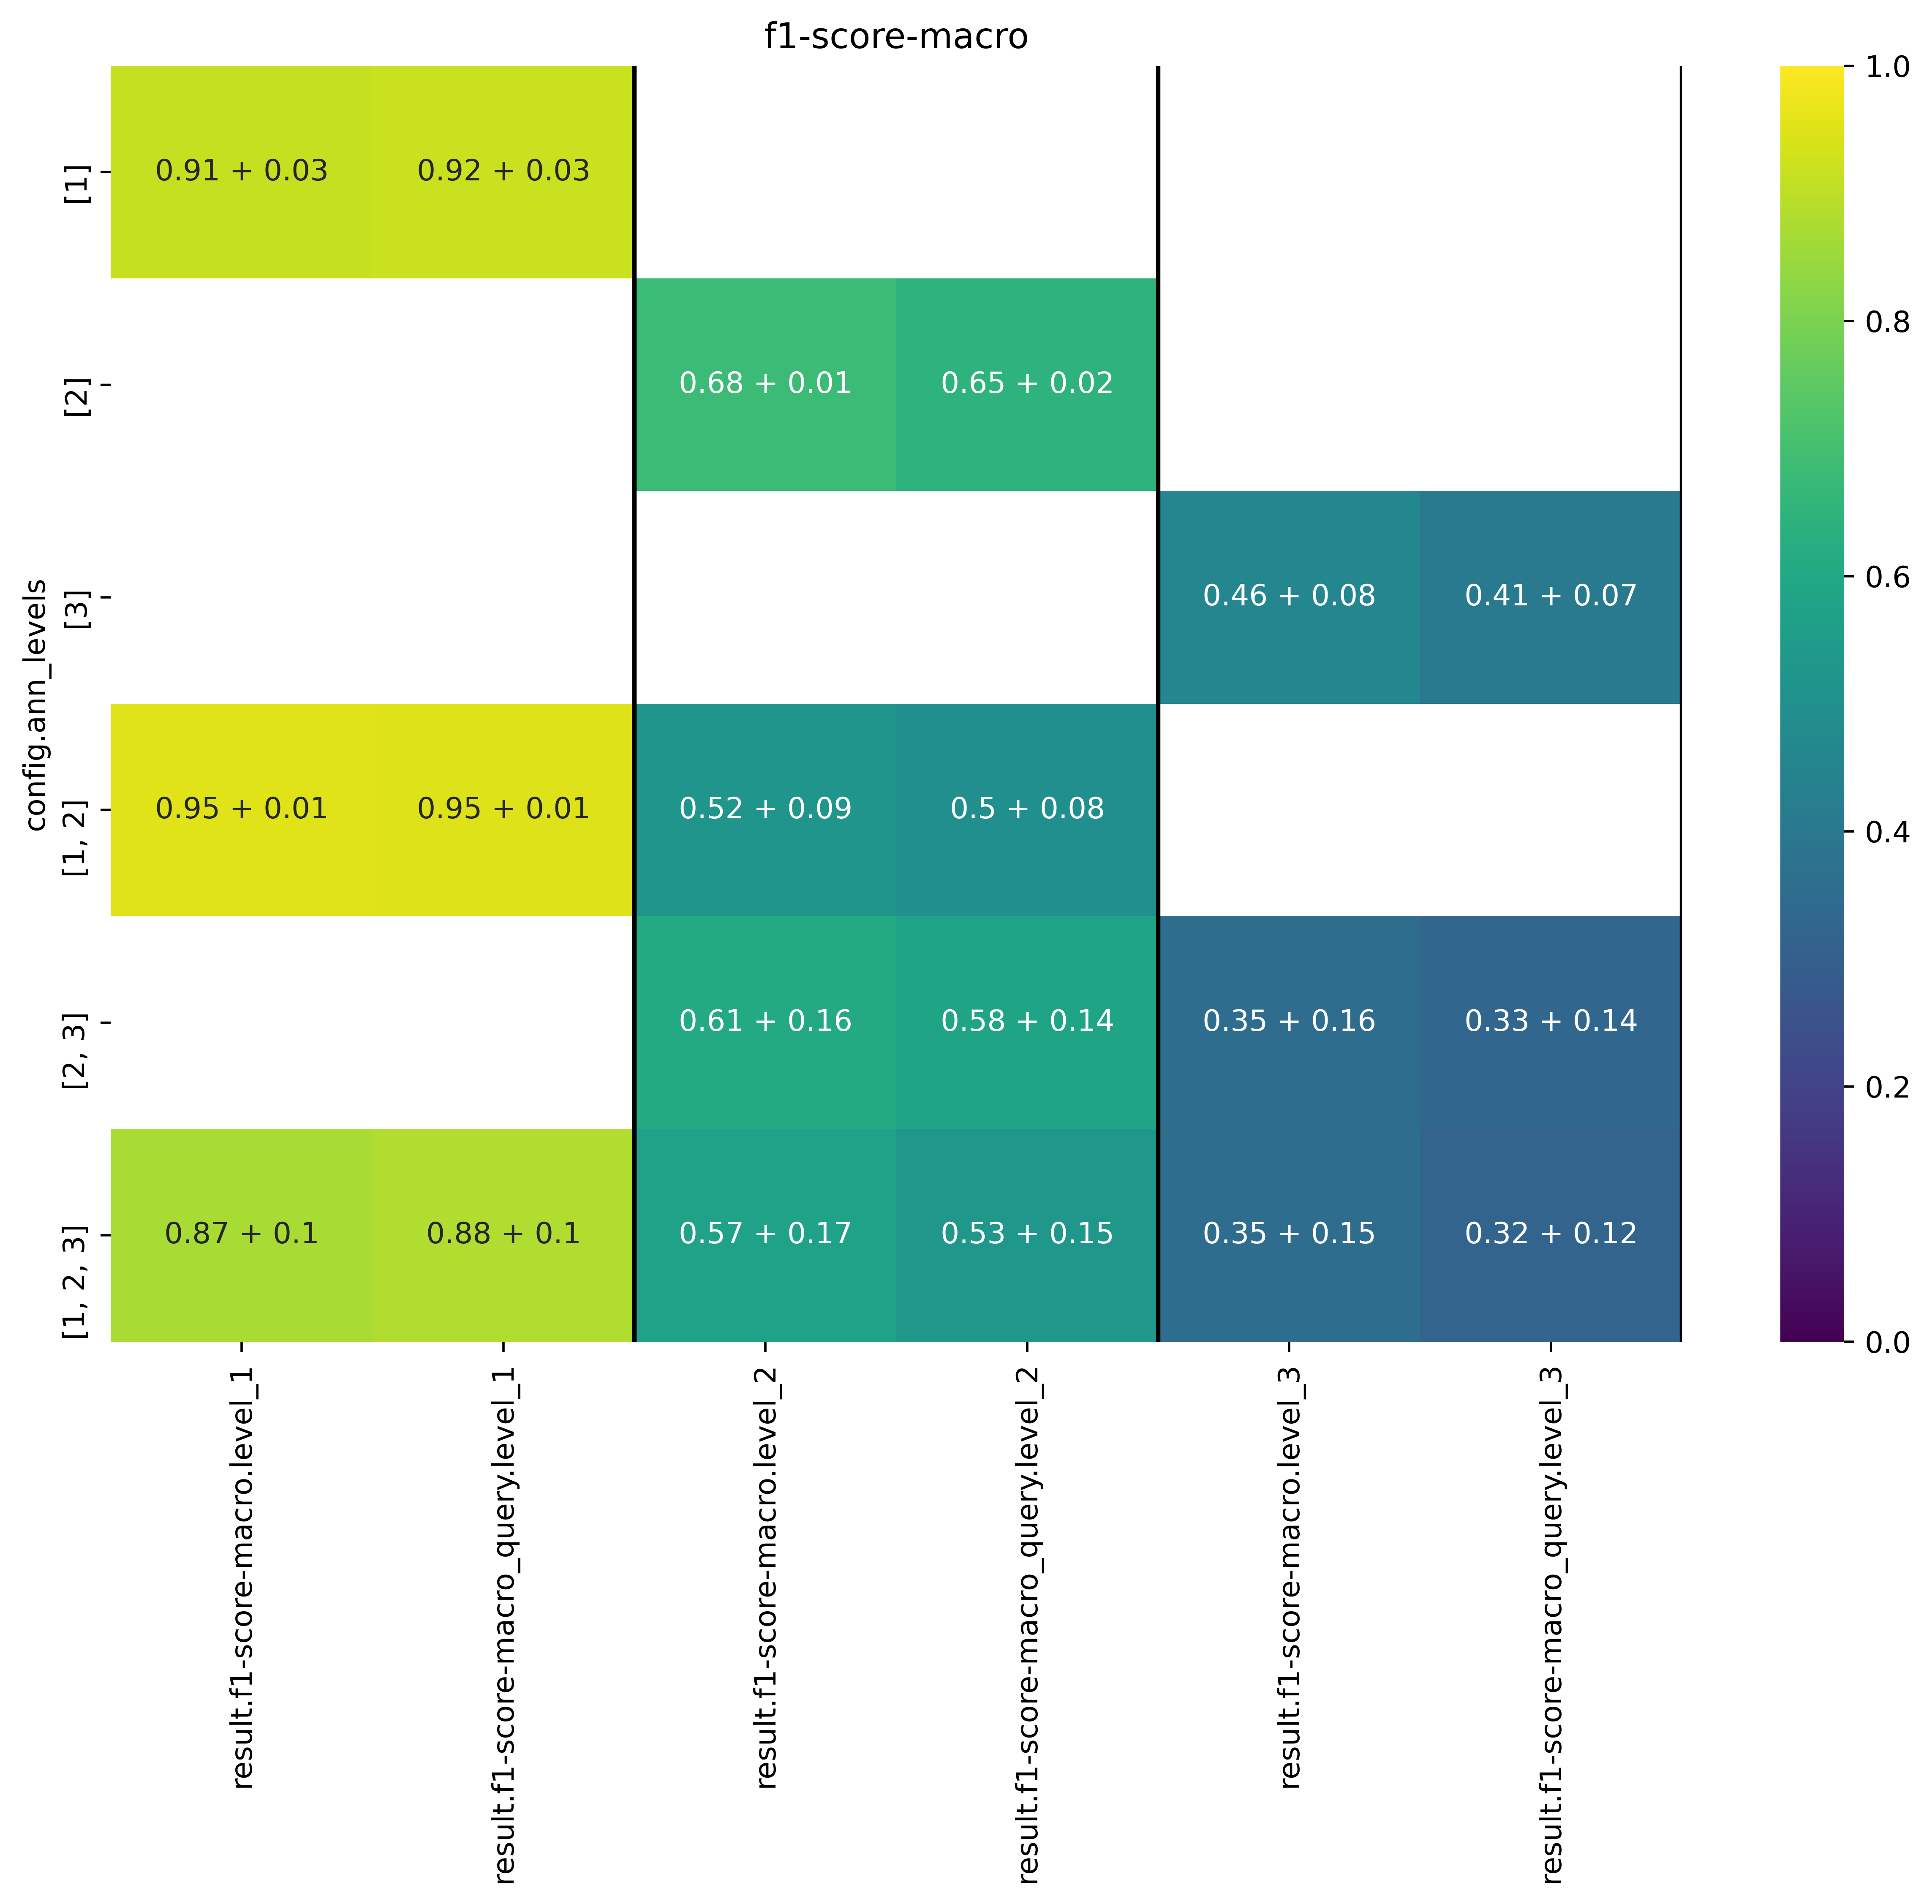

In [7]:
plot(results, 'f1-score-macro')

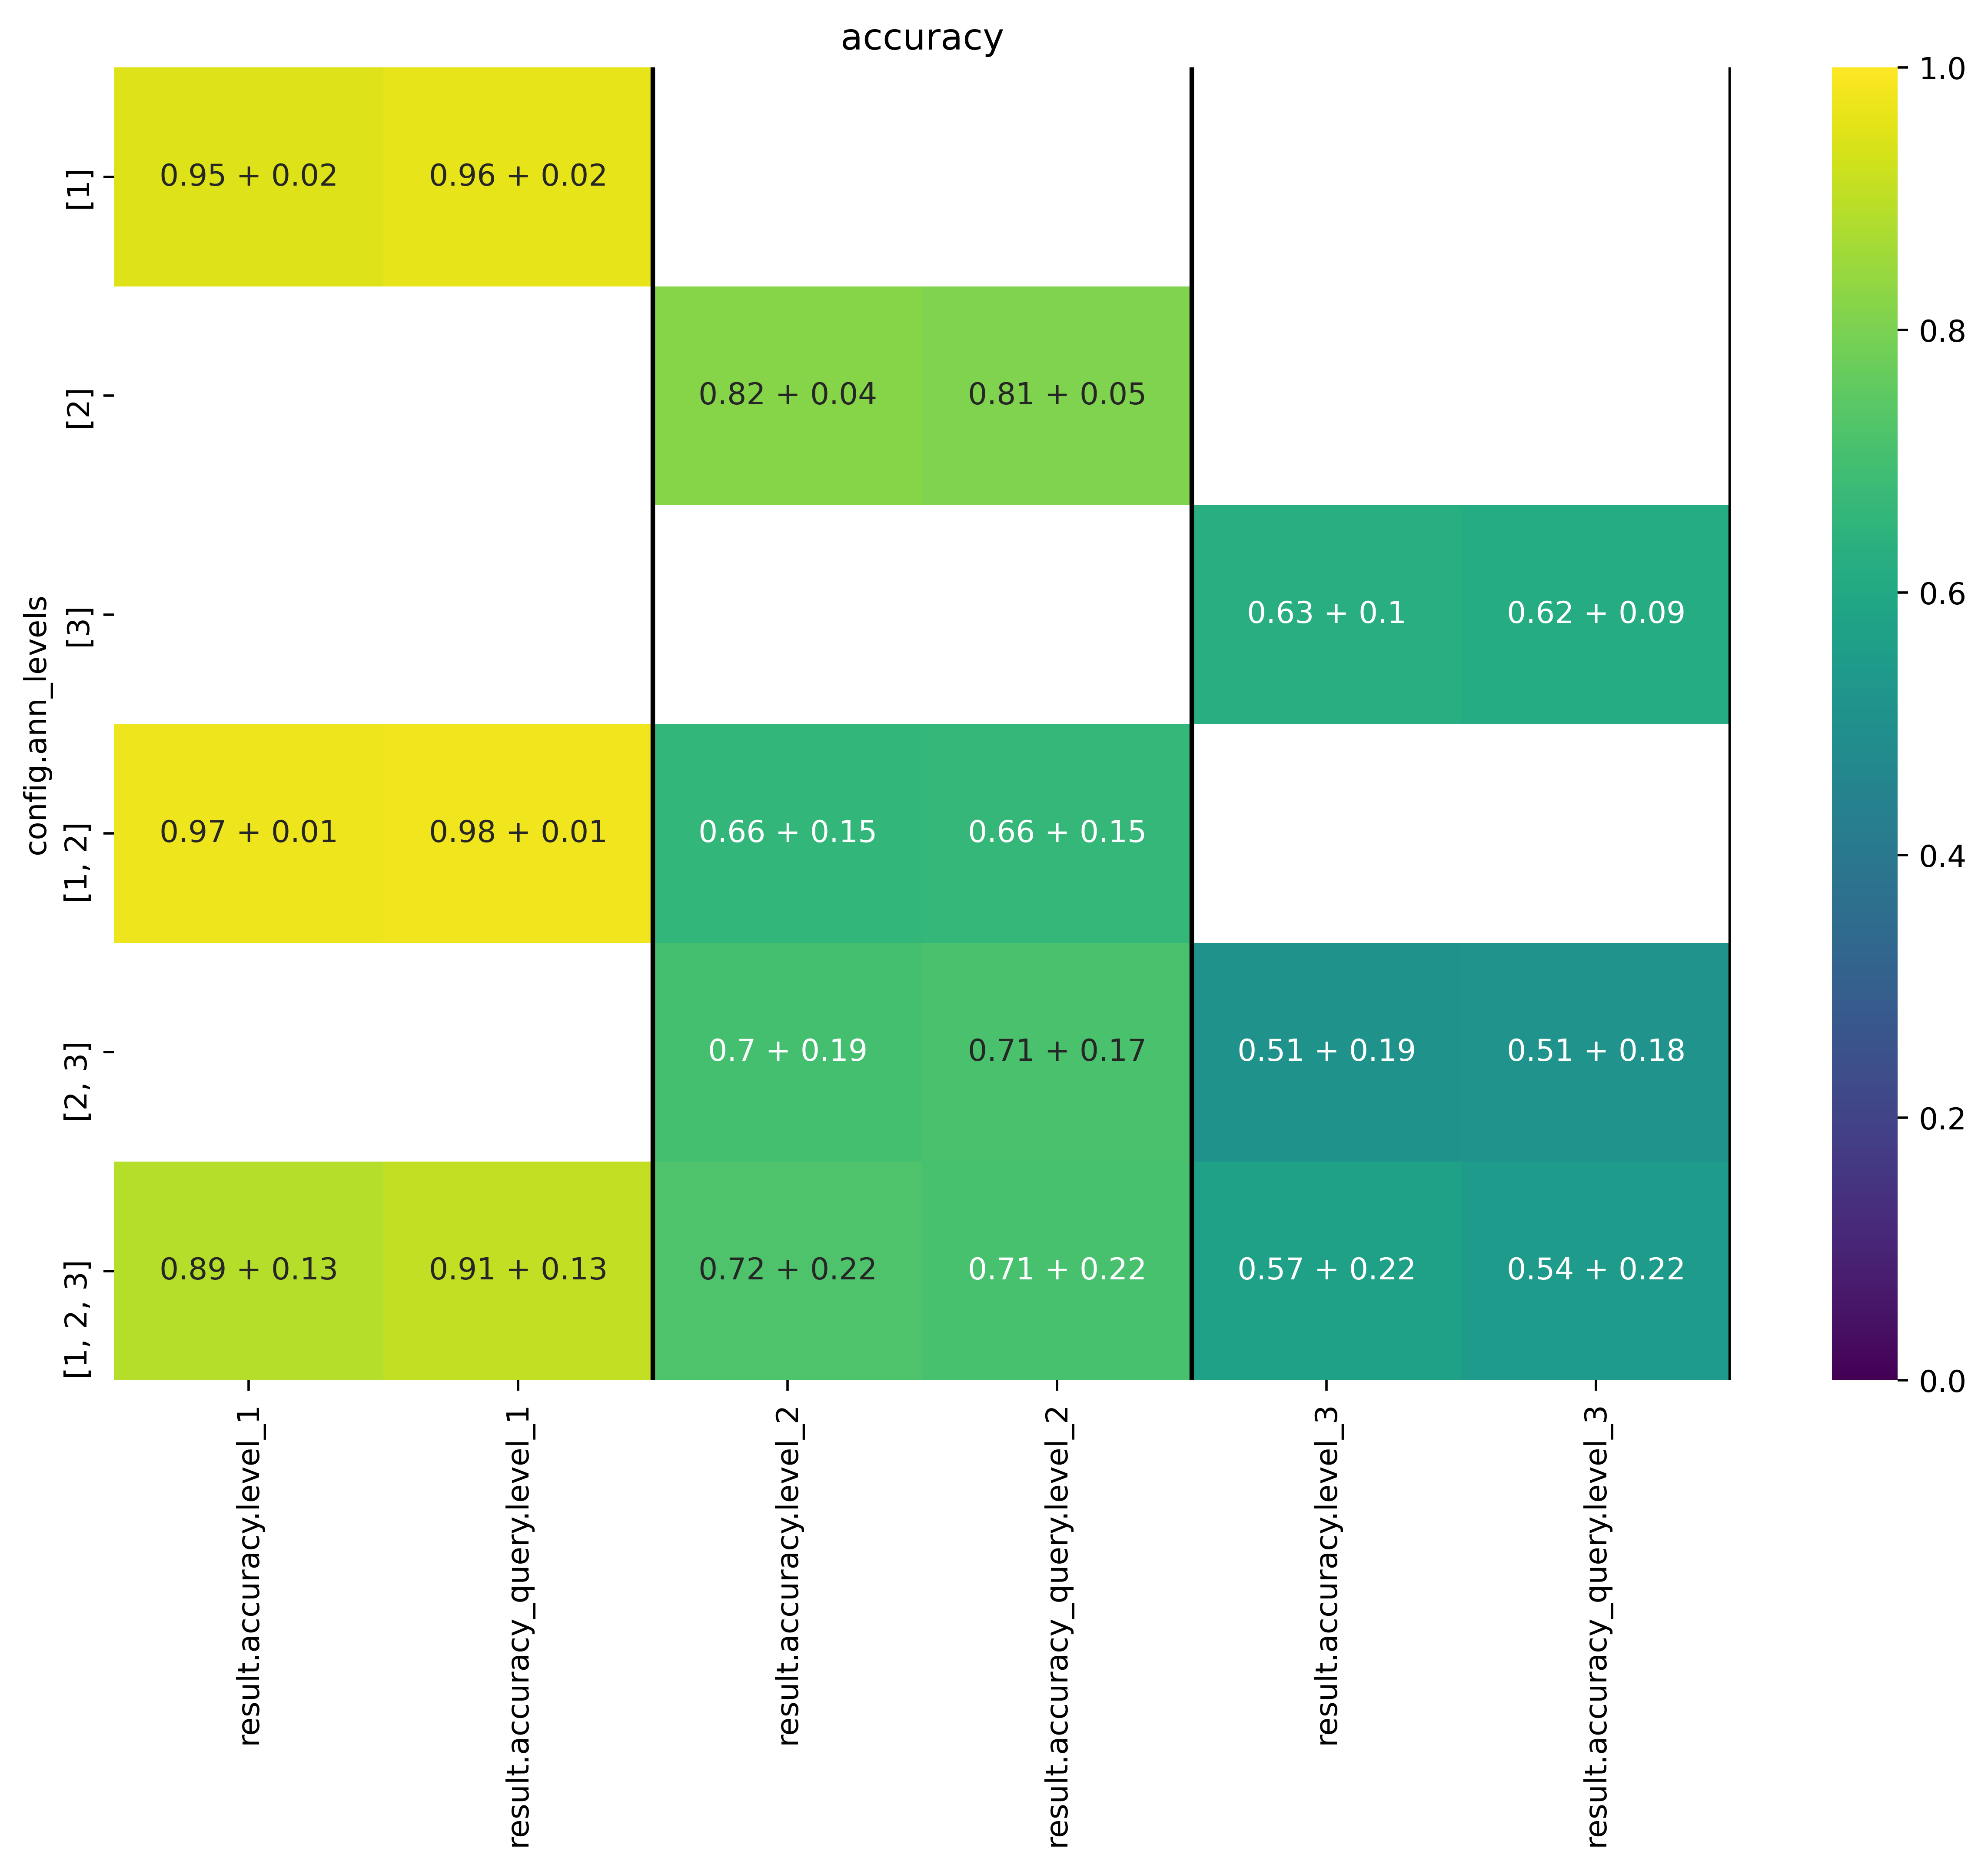

In [8]:
plot(results, 'accuracy')